In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

size=[]
weights=[]
cov=[]
means=[]

def gauss(X, mean_vector, covariance_matrix):
    if (np.abs(np.linalg.det(covariance_matrix))==0):
        print("ERROR")
     # a= (2*np.pi)**(-len(X)/2)*np.abs(np.prod((np.linalg.eigvals(covariance_matrix))))**(-1/2)*np.exp(-np.dot(np.dot((X-mean_vector).T, np.linalg.pinv(covariance_matrix)), (X-mean_vector))/2)
    b= (2*np.pi)**(-len(X)/2)*(np.linalg.det(covariance_matrix))**(-1/2)*np.exp(-np.dot(np.dot((X-mean_vector).T, np.linalg.inv(covariance_matrix)), (X-mean_vector))/2)
     # c= ((1/(((2*math.pi)**(X.shape[0]/2))*((np.linalg.det(covariance_matrix))**0.5)))*math.exp(-0.5*np.matmul(np.matmul((X-mean_vector).T,np.linalg.pinv(covariance_matrix)),(X-mean_vector))))
     # return (2*np.pi)**(-len(X)/2)*np.linalg.det(covariance_matrix)**(-1/2)*np.exp(-np.dot(np.dot((X-mean_vector).T, np.linalg.inv(covariance_matrix)), (X-mean_vector))/2)

    return b

# The only hyperparameter is k ( no.of components for each class)
k=3 
train=['coast','forest','opencountry','street','tallbuilding']

for c, train_file in enumerate(train):
    data=pd.read_csv('dataset/'+train_file+'/train.csv')
    data=data.to_numpy()
    X=data[:,1:]
    size.append(len(X))
    print(f"\n\n\nClass {c}")
#     print(size)
    kmeans=KMeans(n_clusters=k,random_state=0).fit(X)
    # kmeans=KMeans(n_clusters=k).fit(X)
    means_old=kmeans.cluster_centers_
    labels=kmeans.labels_


    N=len(X)
    r_old=np.zeros((len(X),k)) # form a Z ( indicator ) matrix

    for i in range(len(X)):
        r_old[i,labels[i]]=1

    Nq_old=np.sum(r_old,axis=0) # sum conatins the number of elements belonging
                                 # to each cluster

    print("\nOriginal effective number of elements in each cluster")
    print(Nq_old)
    # Initialization

    #cov2 is a 3-d array containing the covariance matrix of each cluster
    cov_old=np.zeros([k,X.shape[1],X.shape[1]])
    Wq_old =np.zeros([k,1]) ## weight of each cluster

    for i in range(k):
        Nq=Nq_old[i]
        Wq_old[i]= Nq/N
        tp=np.zeros([X.shape[1],X.shape[1]])

        for p in range(X.shape[0]):
            le=X[p,:]-means_old[i]
            le=np.reshape(le,[le.shape[0],1])
            tp=tp+r_old[p,i]*(np.dot(le,le.T))
        tp=tp/Nq

        d= np.diag(tp)
        tp=np.diag(d)
        cov_old[i,:,:]=tp.copy()

    ll_old= 0.0
    for n in range(len(X)):
        ll_old = ll_old + np.log(sum([Wq_old[j]*multivariate_normal.pdf(X[n], means_old[j], cov_old[j],allow_singular=True) for j in range(k)]))

    print(f"\nInitial log-likehood = {ll_old}")

    convergence=False
    iter_convergence=0
    run=0
    runs=1000
    epsilon=100

    while (convergence == False and run<runs):

        # ''' --------------------------   E - STEP   -------------------------- '''

        # Initiating the r matrix, every row contains the probabilities
        # for every cluster for this row

        r_new = np.zeros((len(X), k))  # responsibilty matrix

        # Calculating the r matrix
        for n in range(len(X)):
            for i in range(k):
                r_new[n][i] = Wq_old[i] * multivariate_normal.pdf(X[n], means_old[i], cov_old[i],allow_singular=True)
                r_new[n][i] /= sum([Wq_old[j]*multivariate_normal.pdf(X[n], means_old[j], cov_old[j],allow_singular=True) for j in range(k)])

        # Calculating the N effective elemts fro each component
        Nq_new = np.sum(r_new, axis=0)


        # ''' --------------------------   M - STEP   -------------------------- '''


        # Updating the weights list
        Wq_new =np.zeros([k,1]) ## weight of each cluster
        for i in range(k):
            Wq_new[i]= Nq_new[i]/ N


        # Initializing the mean vector as a zero vector
        means_new = np.zeros((k, len(X[0])))

        # Updating the mean vector
        for i in range(k):
            for n in range(len(X)):
                means_new[i] = means_new[i] + r_new[n][i] * X[n]
            means_new[i] = means_new [i]/Nq_new[i]



        # Initiating the list of the covariance matrixes
        cov_new =np.zeros([k,X.shape[1],X.shape[1]])

        # Updating the covariance matrices
        for i in range(k):
            Nq=Nq_new[i]
            tp=np.zeros([X.shape[1],X.shape[1]])

            for p in range(X.shape[0]):
                le=X[p,:]-means_new[i]
                le=np.reshape(le,[le.shape[0],1])
                tp=tp+r_new[p,i]*(np.dot(le,le.T))

            tp=tp/Nq
#             d= np.diag(tp)
#             tp=np.diag(d)
            cov_new[i,:,:]=tp.copy()


        # print(f"\nRun= {run}\n")
#         print(np.sum(Nq_new))
#         print("\nWeights\n")
#         print(np.sum(Wq_new))
#         print(Wq_new)
#         print(np.sum(r_new))
#         print("\n------------------")

        # Calculating log-likelhood
        ll_new=0
        for n in range(len(X)):
            ll_new = ll_new + np.log(sum([Wq_new[j]*multivariate_normal.pdf(X[n], means_new[j], cov_new[j],allow_singular=True) for j in range(k)]))

    #     print(ll_new)
        diff=ll_new-ll_old

    #     print(diff)

        #Convergence condition
        if diff < 1e-3:
            iter_convergence=run
            convergence=True
            break

        else:
            ll_old=ll_new.copy()
            Wq_old= Wq_new.copy()
            means_old=means_new.copy()
            cov_old=cov_new.copy()

        run= run +1

    if convergence==True and run!=runs:
        print("Iterations for convergence=",iter_convergence)
    else:
        print("Estimate has not converged yet, more runs needed")
    print(f"Final log-likehood = {ll_new}")

    print("\nEffective number of elements in each cluster is")
    print(Nq_new)
#     ass=np.sum(Nq_new)
#     print(ass)
    weights.append(Wq_new)
    means.append(means_new)
    cov.append(cov_new)

print("\n##############################################################################")








Class 0

Original effective number of elements in each cluster
[107.  88.  56.]

Initial log-likehood = [5984.27118095]
Iterations for convergence= 14
Final log-likehood = [6472.0725257]

Effective number of elements in each cluster is
[94.7540565  90.35547454 65.89046896]



Class 1

Original effective number of elements in each cluster
[72. 97. 60.]

Initial log-likehood = [7795.38639783]
Iterations for convergence= 17
Final log-likehood = [9460.65986744]

Effective number of elements in each cluster is
[72.03814757 81.06703544 75.89481699]



Class 2

Original effective number of elements in each cluster
[ 88.  97. 102.]

Initial log-likehood = [7129.51225147]
Iterations for convergence= 29
Final log-likehood = [7579.10517945]

Effective number of elements in each cluster is
[91.6808582  98.95059209 96.36854971]



Class 3

Original effective number of elements in each cluster
[75. 86. 43.]

Initial log-likehood = [6780.15348552]
Iterations for convergence= 7
Final log-likehood =

In [3]:
size=np.array(size)
prior_class=size/np.sum(size)

validation_set=['coast','forest','opencountry','street','tallbuilding']
# validation_set=['train_1.csv','train_2.csv','train_3.csv','train_4.csv','train_5.csv']


valid_data=pd.DataFrame()
test_data=pd.DataFrame()
train_data=pd.DataFrame()
for ind, valid_file in enumerate(validation_set):

    X_valid=pd.read_csv('dataset/'+valid_file+'/dev.csv')
    X_valid['y']=ind
    msk = np.random.rand(len(X_valid)) < 0.5  #50-50 splits
    #print(X_valid[msk])
    valid_data=pd.concat([valid_data,X_valid[msk]],ignore_index=True)
    test_data=pd.concat([test_data,X_valid[~msk]],ignore_index=True)
    
for ind, valid_file in enumerate(validation_set):

    X_valid=pd.read_csv('dataset/'+valid_file+'/train.csv')
    X_valid['y']=ind
    
    #print(X_valid[msk])
    #valid_data=pd.concat([valid_data,X_valid[msk]],ignore_index=True)
    #test_data=pd.concat([test_data,X_valid[~msk]],ignore_index=True)
    train_data=pd.concat([train_data,X_valid],ignore_index=True)
    
#print(train_data)
    

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
predicted=[]
real=[]
#k=3
#print(len(validation_set))
for i in range(len(valid_data)):

    X_valid=(valid_data.loc[i,:]).to_numpy()
    #print(X_valid)
    X_valid=X_valid[1:]
    Y_valid=X_valid[-1]
    X_valid=X_valid[:-1]
    real.append(Y_valid)
    

    #for n in range(len(X_valid)):
    ll_n=[]
    for i in range(len(validation_set)):
        ll= np.log(sum([weights[i][j]*multivariate_normal.pdf(X_valid, means[i][j], cov[i][j],allow_singular=True)  for j in range(k)])) + np.log(prior_class[i])
        ll_n.append(ll)
    ll_n=np.array(ll_n)
    predicted.append(np.argmax(ll_n))
    
    #p=index.count(ind)
    #prob=p/len(index)

    #print(prob)
    
print("accuracy on validation set using full covariance matrix and k="+str(k)+ " is " +str(accuracy_score(real,predicted)*100))

<ipython-input-4-a7925384f532>:21: RuntimeWarning: divide by zero encountered in log
  ll= np.log(sum([weights[i][j]*multivariate_normal.pdf(X_valid, means[i][j], cov[i][j],allow_singular=True)  for j in range(k)])) + np.log(prior_class[i])


accuracy on validation set using full covariance matrix and k=3 is 62.08791208791209


<ipython-input-5-7933fc3dfb5a>:19: RuntimeWarning: divide by zero encountered in log
  ll= np.log(sum([weights[i][j]*multivariate_normal.pdf(X_valid, means[i][j], cov[i][j],allow_singular=True)  for j in range(k)])) + np.log(prior_class[i])


accuracy on Training set using full covariance matrix and k=3 is 83.93442622950819


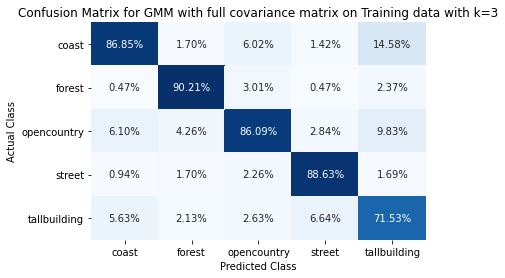

In [5]:
predicted=[]
real=[]
#k=3
#print(len(validation_set))

for i in range(len(train_data)):

    X_valid=(train_data.loc[i,:]).to_numpy()
    #print(X_valid)
    X_valid=X_valid[1:]
    Y_valid=X_valid[-1]
    X_valid=X_valid[:-1]
    real.append(Y_valid)
    

    #for n in range(len(X_valid)):
    ll_n=[]
    for i in range(len(validation_set)):
        ll= np.log(sum([weights[i][j]*multivariate_normal.pdf(X_valid, means[i][j], cov[i][j],allow_singular=True)  for j in range(k)])) + np.log(prior_class[i])
        ll_n.append(ll)
    ll_n=np.array(ll_n)
    predicted.append(np.argmax(ll_n))
    
    #p=index.count(ind)
    #prob=p/len(index)

    #print(prob)
    
print("accuracy on Training set using full covariance matrix and k="+str(k)+ " is " +str(accuracy_score(real,predicted)*100))

confuse=confusion_matrix(real,predicted)

sn.heatmap(confuse/np.sum(confuse,axis=0), annot=True,
    fmt='.2%', cmap='Blues',cbar=False,xticklabels=validation_set,yticklabels=validation_set)
plt.xlabel('Predicted Class')
plt.ylabel("Actual Class")
plt.title('Confusion Matrix for GMM with full covariance matrix on Training data with k='+str(k))
#plt.savefig('Confusion_train_2.png')
#plt.xaxis.set_ticklabels(validation_set); 
#ax.yaxis.set_ticklabels(validation_set[::-1]);
plt.show()

<ipython-input-6-e8945a123578>:19: RuntimeWarning: divide by zero encountered in log
  ll= np.log(sum([weights[i][j]*multivariate_normal.pdf(X_valid, means[i][j], cov[i][j],allow_singular=True)  for j in range(k)])) + np.log(prior_class[i])


accuracy on Testing set using full covariance matrix and k=3 is 63.095238095238095


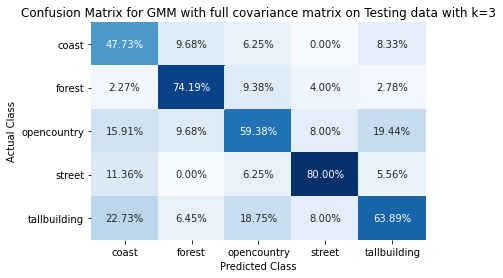

In [6]:
predicted=[]
real=[]
#k=3
#print(len(validation_set))

for i in range(len(test_data)):

    X_valid=(test_data.loc[i,:]).to_numpy()
    #print(X_valid)
    X_valid=X_valid[1:]
    Y_valid=X_valid[-1]
    X_valid=X_valid[:-1]
    real.append(Y_valid)
    

    #for n in range(len(X_valid)):
    ll_n=[]
    for i in range(len(validation_set)):
        ll= np.log(sum([weights[i][j]*multivariate_normal.pdf(X_valid, means[i][j], cov[i][j],allow_singular=True)  for j in range(k)])) + np.log(prior_class[i])
        ll_n.append(ll)
    ll_n=np.array(ll_n)
    predicted.append(np.argmax(ll_n))
    
    #p=index.count(ind)
    #prob=p/len(index)

    #print(prob)
    
print("accuracy on Testing set using full covariance matrix and k="+str(k)+ " is " +str(accuracy_score(real,predicted)*100))

confuse=confusion_matrix(real,predicted)

sn.heatmap(confuse/np.sum(confuse,axis=0), annot=True,
    fmt='.2%', cmap='Blues',cbar=False,xticklabels=validation_set,yticklabels=validation_set)
plt.xlabel('Predicted Class')
plt.ylabel("Actual Class")
plt.title('Confusion Matrix for GMM with full covariance matrix on Testing data with k='+str(k))
#plt.savefig('Confusion_train_2.png')
#plt.xaxis.set_ticklabels(validation_set); 
#ax.yaxis.set_ticklabels(validation_set[::-1]);
plt.show()